In [23]:
import numpy as np

In [24]:
# Load training set (60K images)
X_tr = np.load("kmnist_exp/kmnist-train-imgs.npz")["arr_0"]
y_tr = np.load("kmnist_exp/kmnist-train-labels.npz")["arr_0"]

# Load test set (10K images)
X_te = np.load("kmnist_exp/kmnist-test-imgs.npz")["arr_0"]
y_te = np.load("kmnist_exp/kmnist-test-labels.npz")["arr_0"]

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Preprocess: flatten 28x28 -> 784, normalize to [0,1], convert to tensors
X_train = torch.tensor(X_tr.reshape(-1, 784) / 255.0, dtype=torch.float32)
y_train = torch.tensor(y_tr, dtype=torch.long)
X_test = torch.tensor(X_te.reshape(-1, 784) / 255.0, dtype=torch.float32)
y_test = torch.tensor(y_te, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256)

In [26]:
from custom_optimizer import MyAdamW

model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = MyAdamW(model.parameters(), lr=1e-3)

Parameters: 109,386


Epoch  1 | Train Loss: 0.7288 | Val Loss: 0.7477
Epoch  2 | Train Loss: 0.3621 | Val Loss: 0.6249
Epoch  3 | Train Loss: 0.2770 | Val Loss: 0.5524
Epoch  4 | Train Loss: 0.2210 | Val Loss: 0.5062
Epoch  5 | Train Loss: 0.1811 | Val Loss: 0.4826
Epoch  6 | Train Loss: 0.1523 | Val Loss: 0.4489
Epoch  7 | Train Loss: 0.1296 | Val Loss: 0.4785
Epoch  8 | Train Loss: 0.1106 | Val Loss: 0.4536
Epoch  9 | Train Loss: 0.0943 | Val Loss: 0.4480
Epoch 10 | Train Loss: 0.0810 | Val Loss: 0.4431
Epoch 11 | Train Loss: 0.0688 | Val Loss: 0.4482
Epoch 12 | Train Loss: 0.0593 | Val Loss: 0.4786
Epoch 13 | Train Loss: 0.0518 | Val Loss: 0.4834
Epoch 14 | Train Loss: 0.0438 | Val Loss: 0.4936
Epoch 15 | Train Loss: 0.0367 | Val Loss: 0.5057
Epoch 16 | Train Loss: 0.0302 | Val Loss: 0.5207
Epoch 17 | Train Loss: 0.0264 | Val Loss: 0.5372
Epoch 18 | Train Loss: 0.0230 | Val Loss: 0.5942
Epoch 19 | Train Loss: 0.0188 | Val Loss: 0.5719
Epoch 20 | Train Loss: 0.0177 | Val Loss: 0.6059
Epoch 21 | Train Los

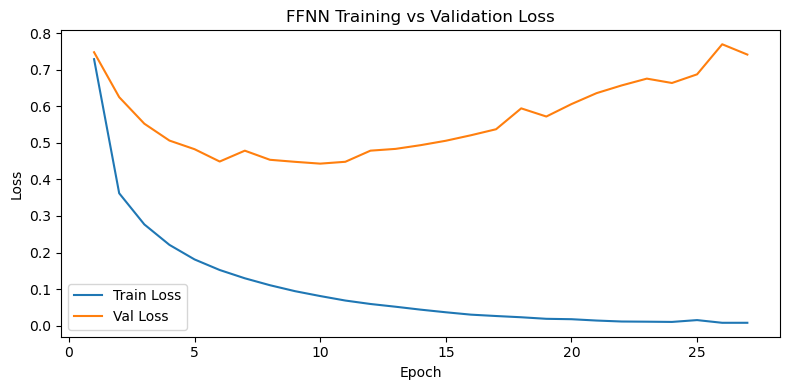

In [27]:
train_losses = []
val_losses = []

for epoch in range(27):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        loss_train = loss_fn(model(X_batch), y_batch)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        total_loss += loss_train.item() * len(X_batch)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_loss += loss_fn(model(X_batch), y_batch).item() * len(X_batch)

    train_losses.append(total_loss / len(X_train))
    val_losses.append(val_loss / len(X_test))
    print(f"Epoch {epoch+1:2d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FFNN Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
model.eval()
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        correct += (model(X_batch).argmax(1) == y_batch).sum().item()
print(f"Test accuracy: {correct / len(X_test):.4f}")

Test accuracy: 0.8849


## CNN Approach

In [13]:
import matplotlib.pyplot as plt

# Reshape data for CNN: (N, 1, 28, 28)
X_train_cnn = torch.tensor(X_tr.reshape(-1, 1, 28, 28) / 255.0, dtype=torch.float32)
X_test_cnn = torch.tensor(X_te.reshape(-1, 1, 28, 28) / 255.0, dtype=torch.float32)

train_loader_cnn = DataLoader(TensorDataset(X_train_cnn, y_train), batch_size=256, shuffle=True)
test_loader_cnn = DataLoader(TensorDataset(X_test_cnn, y_test), batch_size=256)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # -> (16, 28, 28)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # -> (32, 14, 14)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # -> (64, 7, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (16, 14, 14)
        x = self.pool(self.relu(self.conv2(x)))  # (32, 7, 7)
        x = self.pool(self.relu(self.conv3(x)))  # (64, 3, 3)
        x = x.flatten(1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

cnn = CNN().to(device)
cnn_loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

In [15]:
for epoch in range(10):
    cnn.train()
    total_loss = 0
    for X_batch, y_batch in train_loader_cnn:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        loss = cnn_loss_fn(cnn(X_batch), y_batch)
        cnn_optimizer.zero_grad()
        loss.backward()
        cnn_optimizer.step()
        total_loss += loss.item() * len(X_batch)
    print(f"Epoch {epoch+1:2d} | Loss: {total_loss / len(X_train_cnn):.4f}")

Epoch  1 | Loss: 0.7037
Epoch  2 | Loss: 0.2154
Epoch  3 | Loss: 0.1391
Epoch  4 | Loss: 0.1024
Epoch  5 | Loss: 0.0766
Epoch  6 | Loss: 0.0619
Epoch  7 | Loss: 0.0499
Epoch  8 | Loss: 0.0431
Epoch  9 | Loss: 0.0357
Epoch 10 | Loss: 0.0278


In [16]:
cnn.eval()
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader_cnn:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        correct += (cnn(X_batch).argmax(1) == y_batch).sum().item()
print(f"CNN Test accuracy: {correct / len(X_test_cnn):.4f}")

CNN Test accuracy: 0.9426


### Visualizing Learned Convolutional Filters

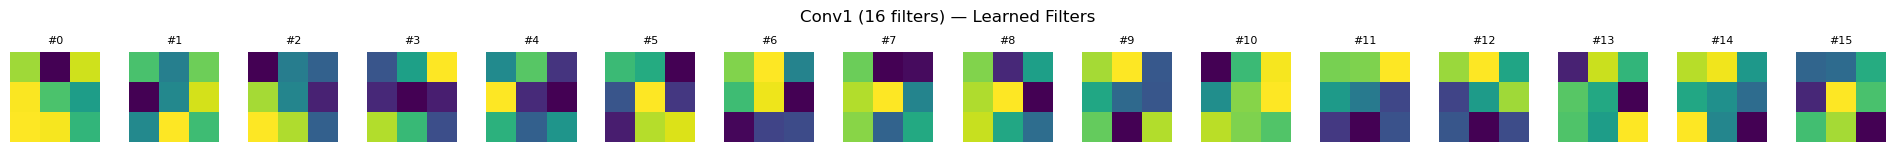

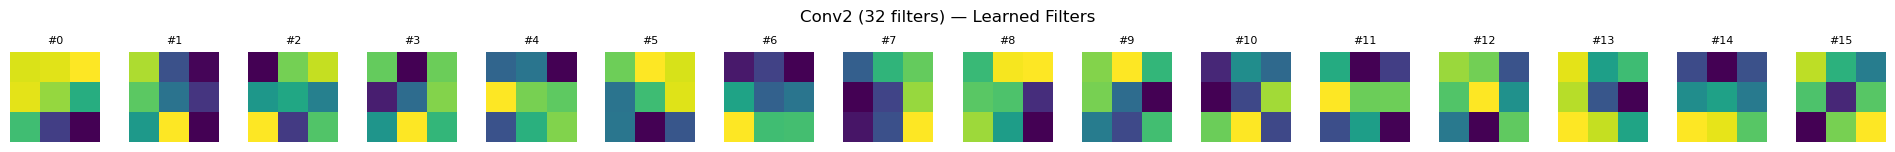

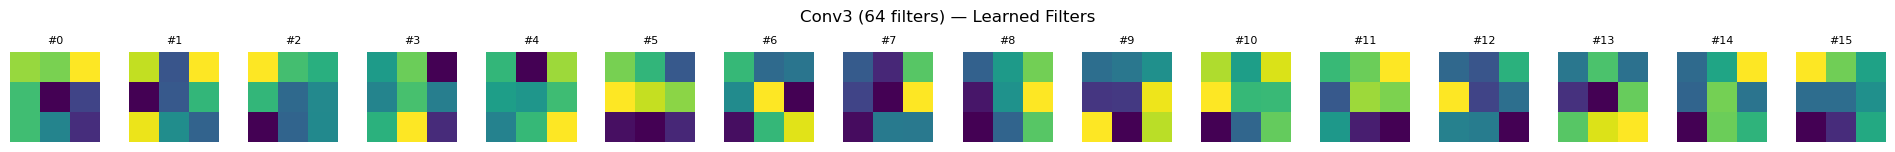

In [17]:
# Visualize the learned filters for each conv layer
conv_layers = [("Conv1 (16 filters)", cnn.conv1), ("Conv2 (32 filters)", cnn.conv2), ("Conv3 (64 filters)", cnn.conv3)]

for name, layer in conv_layers:
    weights = layer.weight.data.cpu()
    n_filters = min(weights.shape[0], 16)  # show up to 16 filters
    fig, axes = plt.subplots(1, n_filters, figsize=(n_filters * 1.2, 1.5))
    fig.suptitle(f"{name} — Learned Filters", fontsize=12)
    for i in range(n_filters):
        # For conv1, filters are (1,3,3); for deeper layers, average across input channels
        filt = weights[i].mean(dim=0)
        axes[i].imshow(filt, cmap="viridis")
        axes[i].axis("off")
        axes[i].set_title(f"#{i}", fontsize=8)
    plt.tight_layout()
    plt.show()

### Visualizing Feature Maps (Activations) Per Layer

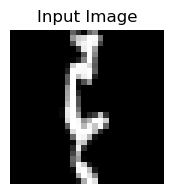

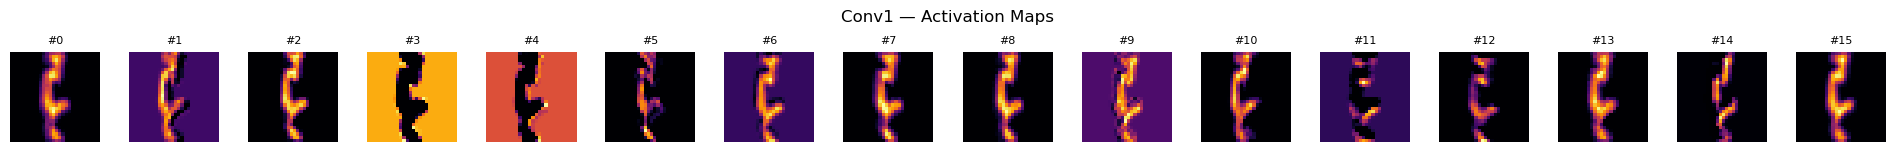

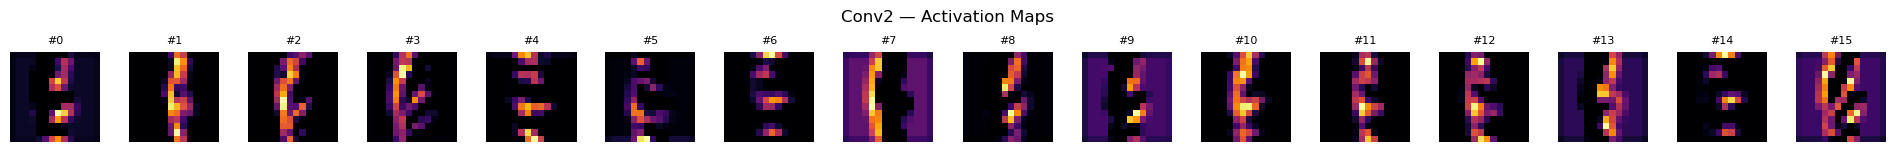

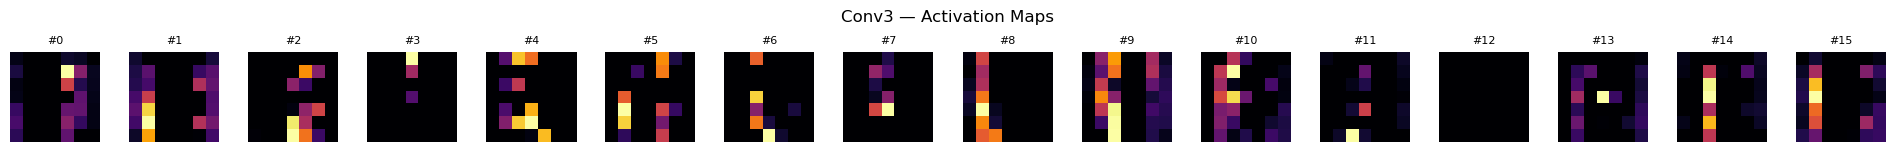

In [18]:
# Pass a single test image through each layer and visualize activations
sample_img = X_test_cnn[0:1].to(device)

cnn.eval()
activations = {}
with torch.no_grad():
    x = sample_img
    for name, layer in [("Conv1", cnn.conv1), ("Conv2", cnn.conv2), ("Conv3", cnn.conv3)]:
        x = cnn.relu(layer(x))
        activations[name] = x.cpu().squeeze(0)  # (C, H, W)
        x = cnn.pool(x)

# Show the input image
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(sample_img.cpu().squeeze(), cmap="gray")
ax.set_title("Input Image")
ax.axis("off")
plt.show()

# Show activation maps for each conv layer
for name, act in activations.items():
    n_maps = min(act.shape[0], 16)
    fig, axes = plt.subplots(1, n_maps, figsize=(n_maps * 1.2, 1.5))
    fig.suptitle(f"{name} — Activation Maps", fontsize=12)
    for i in range(n_maps):
        axes[i].imshow(act[i], cmap="inferno")
        axes[i].axis("off")
        axes[i].set_title(f"#{i}", fontsize=8)
    plt.tight_layout()
    plt.show()